# Optical character recognition by pattern matching

## Why this strategy

Please read the README on why a general OCR solution like Tesseract did not work out. This solution is heavily inspired by [Credit card OCR with OpenCV and Python](https://www.pyimagesearch.com/2017/07/17/credit-card-ocr-with-opencv-and-python/)

## The scope of this workbook

This is an example in how to do optical character recognition(OCR) of numbers based on pattern mathcing.
This solution seems to work fine since we are only interested in only one font, Exocet.
We are storing a reference picture of all the numbers.
When analysing the image for numbers, we will cut that picture up to characters, analyse them based on the reference, get the numerical value, and build back the original number.

## The reference picture

OpenCV is used to read the image and do further transformations on it, as you'll see. For now let's just load the reference picture.
matplotlib is only used to show the picture here in Jupyter.

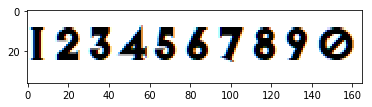

In [2]:
import cv2
# matplotlib only used to show these results in Jupyter. It is not part of the actual solution.
%matplotlib inline
from matplotlib import pyplot as plt
reference = cv2.imread("../tests/test_data/exocet_heavy_digits_reference.PNG")
plt.imshow(reference)

## Convert the reference to gray

We do not need the color information. The image is on the grayscale. With this conversion we can be sure OpenCV will treat it as such.

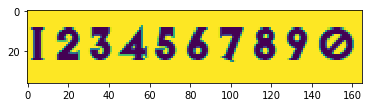

In [3]:
reference_gray = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
plt.imshow(reference_gray)

## Load a screenshot

Throughout the game a screenshot will be taken of the game periodically.
Right here we are not demonstrating that behaviour, we will use a static image as a source.
This image is also used for testing purposes.

We could load the image as grayscale, however in the real applicaiton the screenshots from the game are always colored. That is why this workbook follows that same flow too.

**NOTE:** The colours look funny here in Jupyter. That is not the case in actual program run. This difference is not yet understood.

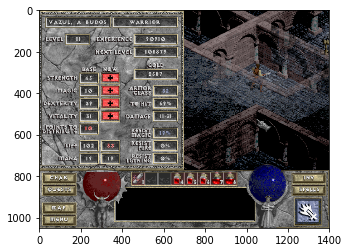

In [4]:
character_tab_screenshot = cv2.imread("../tests/test_data/character_screen_1440_0.PNG")
# This conversion only needed for Jupyter. OpenCV is BGR by default, while matplotlib is RGB.
character_tab_screenshot = cv2.cvtColor(character_tab_screenshot,cv2.COLOR_BGR2RGB)
plt.imshow(character_tab_screenshot)

## Crop for the interesting part

As part of this tutorial we will analyse the current experience points. We are lucky, because this text box is always at the same place. Let's crop that part out:

width=1400,height=1050


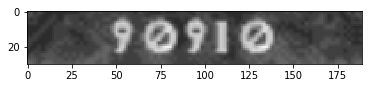

In [5]:
# The game can run in different resolutions. We want to dynamically adjust to that, so let's check the actual resolution.
width = character_tab_screenshot.shape[1]
height = character_tab_screenshot.shape[0]
print("width={},height={}".format(width,height))

# These are constants, the interesting text box is always relatively at the same place
x_start_rel = 470/1400
x_size_rel = 190/1400
y_start_rel = 125/1050
y_size_rel = 30/1050

# Based on the actual resolution now we know the pixel perfect coordinates we need
x_start_abs = int(x_start_rel * width)
x_size_abs = int(x_size_rel * width)
y_start_abs = int(y_start_rel * height)
y_size_abs = int(y_size_rel * height)

# Let's crop!
cropped_xp = character_tab_screenshot[y_start_abs:y_start_abs +
                                       y_size_abs, x_start_abs:x_start_abs+x_size_abs]
plt.imshow(cropped_xp)

## Removing background noise

The image contains a lot of background noise. We want to clean it up, for the pattern matching to have an easier job.
A threshold filter is used from OpenCV. Everything that is below the minimum 150 level is thresholded to zero.
The maximum value has no relevance right now


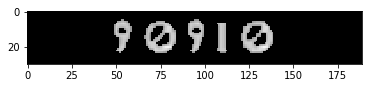

In [6]:
ret, background_cleaned = cv2.threshold(cropped_xp, 150, 400, cv2.THRESH_TOZERO)
plt.imshow(background_cleaned)

## Binarise the image

Still let's simplify the image. Everything below the threshold goes to zero, everythin above it goes to the maximum value, now 255, meaning full white.

By experience cleaning up the background beforehand in the previous step is needed, it helps to guarantee stable results.

Leaving out this step again results in some low amounts of errors. This setup is by far perfect but so far seems stable.

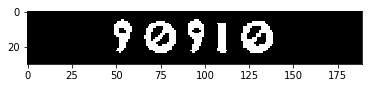

In [7]:
ret, binarised = cv2.threshold(background_cleaned, 100, 255, cv2.THRESH_BINARY)    
plt.imshow(binarised)

## Convert to gray

For further contour analysis we need to convert the format of the picture. Experienced issue later on if this conversion is missing: 

(-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'

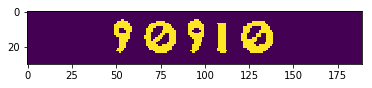

In [8]:
numbers_in_gray = cv2.cvtColor(binarised, cv2.COLOR_BGR2GRAY)
plt.imshow(numbers_in_gray)

## Identify digits

Let's brake this image apart to digits. From then on it will be easy to compare it to our reference image.

In this example we are not analyzing all digits, only one. As noted below, the contours are not ordered left-to-right by default. That is easy to solve with a sorting, but that is not included in this example. 

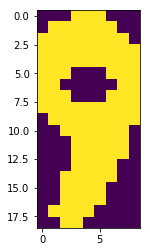

In [10]:
from imutils import contours
import imutils

contours = cv2.findContours(numbers_in_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[1]
# The contours are not yet sorted. This can be done with imutils.sort_contours, or worst case by their x coordinates.
# I'm using index number 3, because I already know in this example that will be my first number.
(x, y, w, h) = cv2.boundingRect(contours[3])
number_to_recognize = numbers_in_gray[y:y + h, x:x + w]
plt.imshow(number_to_recognize)

Just for fun we can apply the same cropping on the original image, getting the same number '9'.

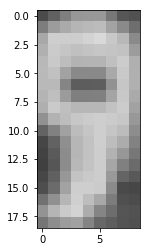

In [11]:
number_to_recognize_hd = cropped_xp[y:y + h, x:x + w]
plt.imshow(number_to_recognize_hd)

## Pattern matching

We have the reference image, we have the digit we want to recognize. Whats left is pattern matching.

In [12]:
match = cv2.matchTemplate(reference_gray, number_to_recognize, cv2.TM_CCORR_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
print("The x coordinate of the searched image in the refence is={}".format(max_loc[0]))

The x coordinate of the searched image in the refence is=136


Since we understand the refence image, based on the coordinates we can easily identify which number is identified.

In [168]:
#if (max_loc[0]==136):
#    return 9

To prove this works, let's do a cross check. Based on the matched pattern we will cut from the reference image.
We are expecting to get the number nine, just like we searched for. Right-bottom corner is not trivial from the coordinates, I'm cheating there. The x coordinates are already good enough for identifying the charachters.

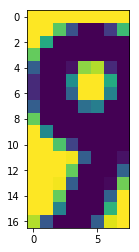

In [13]:
cross_check_from_reference = reference_gray[min_loc[1]:25,min_loc[0]:max_loc[0]]
plt.imshow(cross_check_from_reference)

## Success

We declare success. The following process demonstrates identifying only one digit. As the current solution and tests show, this method is successful at analyzing longer numbers too.

Challenge for the future: this method was not yet tested for real text, where the reference image will be a lot bigger.